In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import scipy.ndimage as ndimage
from skimage.morphology import ball, binary_closing, remove_small_objects, binary_dilation, binary_erosion

c:\Users\DELL\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
path_to_data = "../results/femur_tibia_mask.nii.gz"

In [3]:
mask_vol = nib.load(path_to_data)
mask_vol


In [4]:
print(mask_vol.header)


<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 216   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1.       0.869141 0.869141 2.       1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 222.5
qoffset_y       : 222.5
qoffset_z       : -900.5
sro

Summary of Segmentation Mask
Shape: (512, 512, 216) → 216 axial slices of 512×512 pixels

Voxel size: (0.869 × 0.869 × 2.0 mm³) 

Datatype: 8-bit unsigned integer (uint8) — suitable for labeled masks

Physical size of volume (approx.):

Width: 512 × 0.869 mm ≈ 445 mm

Height: 512 × 0.869 mm ≈ 445 mm

Depth: 216 × 2.0 mm = 432 mm


In [5]:
mask = mask_vol.get_fdata() # get image array data
affine = mask_vol.affine # gets affine transformation matrix associated with the volume data
affine


array([[-8.69140983e-01,  0.00000000e+00,  0.00000000e+00,
         2.22500000e+02],
       [ 0.00000000e+00, -8.69140983e-01,  0.00000000e+00,
         2.22500000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  2.00000000e+00,
        -9.00500000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

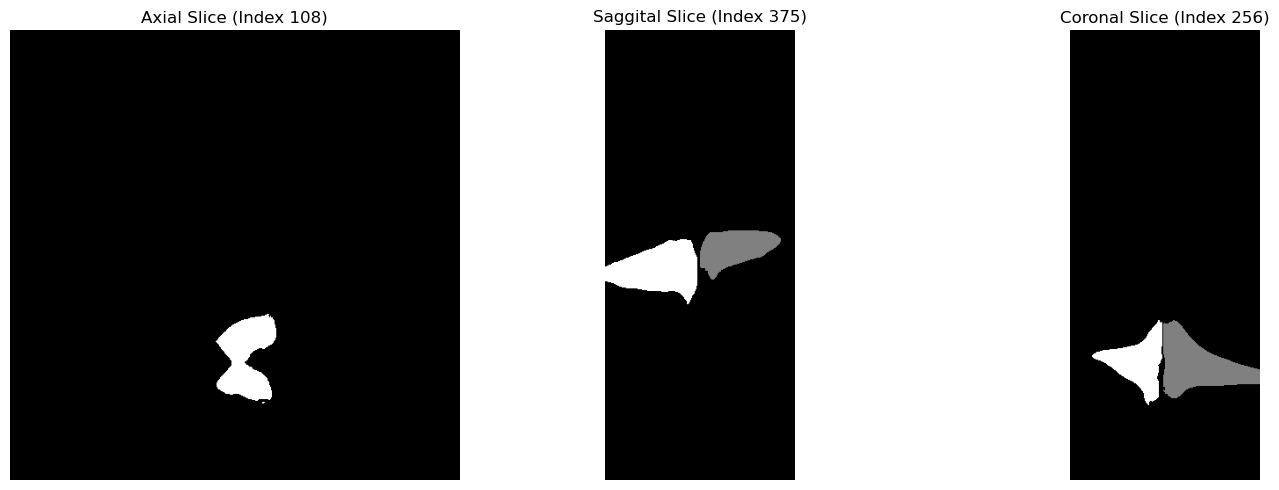

In [6]:
def plot_slices(data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Axial slice 
    axes[0].imshow(data[:, :, 108], cmap='gray')
    axes[0].set_title('Axial Slice (Index 108)')
    axes[0].axis('off')

    # Coronal slice
    axes[1].imshow(data[375, :, :], cmap='gray')
    axes[1].set_title('Saggital Slice (Index 375)')
    axes[1].axis('off')
    # Sagittal slice
    axes[2].imshow(data[:, 256, :], cmap='gray')
    axes[2].set_title('Coronal Slice (Index 256)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

plot_slices(mask)


Extract tibia from the bone

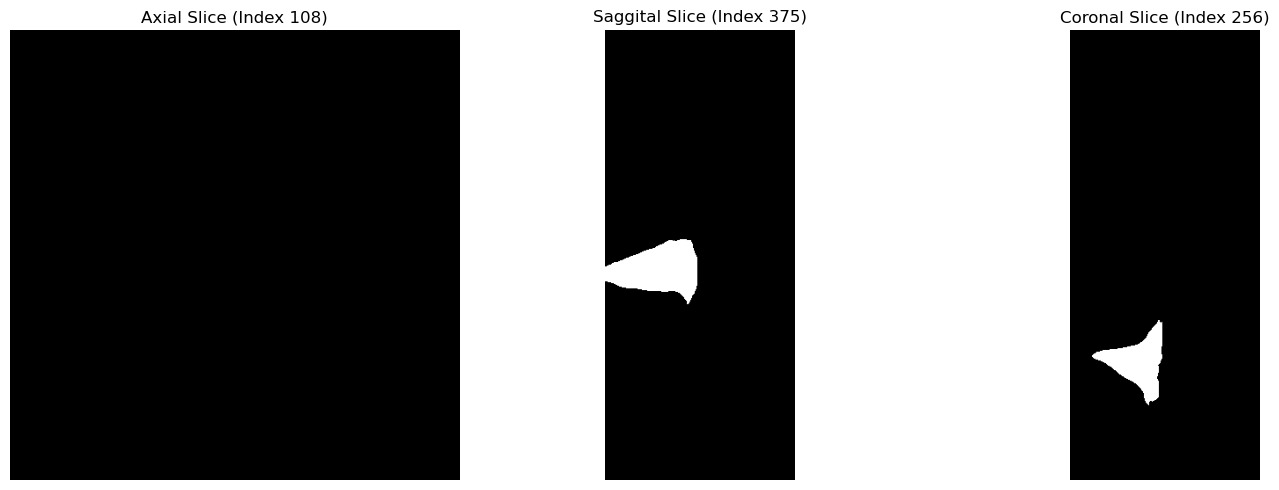

In [7]:
tibia_mask = (mask == 2)

plot_slices(tibia_mask)


In [8]:
from pathlib import Path

labelled_mask = tibia_mask.astype(np.uint8)  # NIfTI format expects int types

nii_mask = nib.Nifti1Image(labelled_mask, affine=mask_vol.affine)

nib.save(nii_mask, Path("../results")/"task_4_tibia_mask.nii.gz")


Tibia Mask Expansion (2 mm)

In [9]:
def get_voxel_spacing(affine):
    spacing_x = np.linalg.norm(affine[:3, 0])
    spacing_y = np.linalg.norm(affine[:3, 1])
    spacing_z = np.linalg.norm(affine[:3, 2])
    return spacing_x, spacing_y, spacing_z

spacing = get_voxel_spacing(affine)
print(f"Voxel spacing (mm): {spacing}")


Voxel spacing (mm): (0.8691409826278687, 0.8691409826278687, 2.0)


In [10]:
# calculate how many voxels we need to expand by 2 mm
def calculate_expansion_voxels(spacing, expansion_mm=2):
    radius_voxels = [int(np.ceil(expansion_mm / s)) for s in spacing]
    return radius_voxels

calculate_expansion_voxels(spacing)


[3, 3, 1]

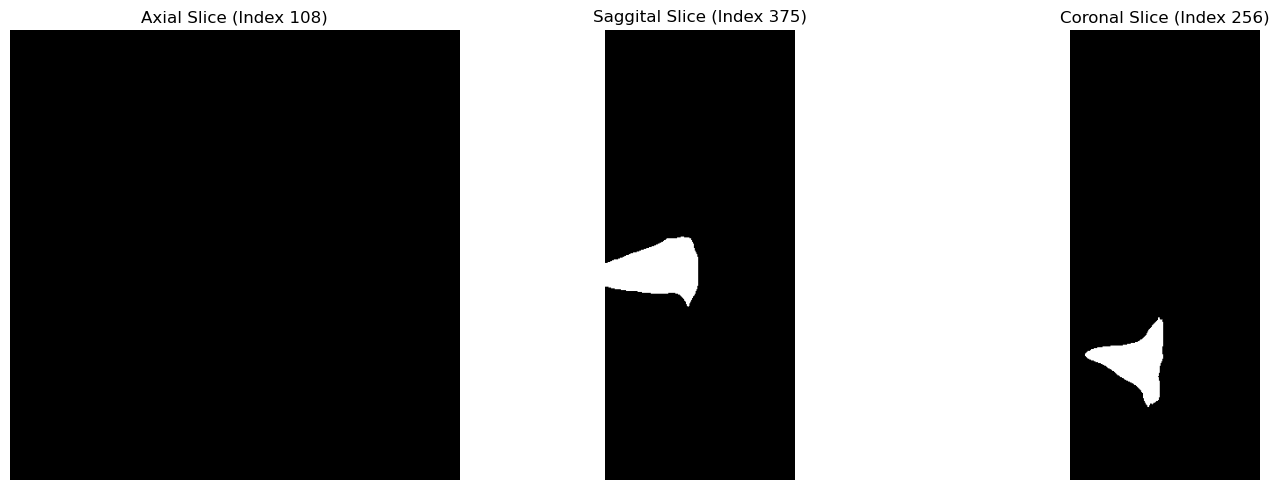

In [11]:
from scipy.ndimage import distance_transform_edt



def expand_mask(mask, spacing, expansion_mm):
    # Compute distance transform of the background (~mask)
    distance = distance_transform_edt(~mask, sampling=spacing)
    # Include original mask plus points within expansion_mm
    expanded = mask | (distance <= expansion_mm)
    return expanded

tibia_expanded = expand_mask(tibia_mask, spacing, 2)

expanded_mask = np.zeros_like(mask)
expanded_mask[tibia_expanded] = 2



plot_slices(expanded_mask)


In [12]:
expanded_img = nib.Nifti1Image(expanded_mask.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(expanded_img, Path("../results")/'task4_tibia_mask_expanded_2mm.nii.gz')


Expand Mask by 4 mm

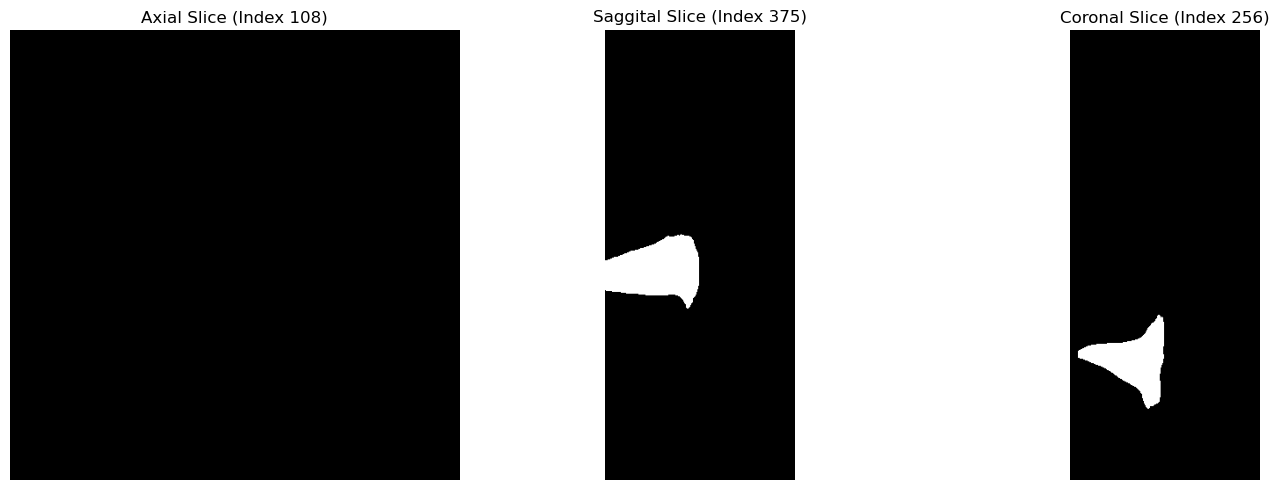

In [13]:

tibia_expanded = expand_mask(tibia_mask, spacing, 4)

expanded_mask_4mm = np.zeros_like(mask)
expanded_mask_4mm[tibia_expanded] = 2

plot_slices(expanded_mask_4mm)

In [14]:
expanded_img = nib.Nifti1Image(expanded_mask_4mm.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(expanded_img, Path("../results")/'task4_tibia_mask_expanded_4mm.nii.gz')


Randmized contour adjustment - tibia mask

In [15]:
def randomized_contour_adjustment(original_mask, spacing, expansion_mm, seed):
   
    if seed is not None:
        np.random.seed(seed)
    
    # 1) distance (in mm) from each background voxel to original mask
    #    distance[i,j,k] = min distance (mm) to a True voxel in original_mask
    distance = distance_transform_edt(
        ~original_mask,
        sampling=spacing
    )
    
    # 2) draw a random expansion radius for *every* voxel in the volume
    #    range [0, expansion_mm]
    random_offsets = np.random.rand(*original_mask.shape) * expansion_mm
    
    # 3) build the new mask:
    #    - keep all original voxels
    #    - add background voxels only if distance <= that voxel’s random offset
    randomized = original_mask | (
        (distance <= random_offsets) &
        (~original_mask)
    )
    
    return randomized

# ---------------------------------------------------------------------
# Example usage for femur and tibia:

# assume you already have:
#   mask          : int32 ndarray with labels {0,1,2}
#   spacing       : (0.89, 0.89, 2.0)
#   expansion_mm  : 2.0

# First randomized adjustment (seed=42)
tibia_rand1 = randomized_contour_adjustment(tibia_mask, spacing, 2.0, seed=42)

# Second randomized adjustment (different seed)
tibia_rand2 = randomized_contour_adjustment(tibia_mask, spacing, 2.0, seed=99)

# Combine into labeled masks
rand_mask1 = np.zeros_like(mask, dtype=np.int32)
rand_mask1[tibia_rand1] = 2

rand_mask2 = np.zeros_like(mask, dtype=np.int32)
rand_mask2[tibia_rand2] = 2

# Now you have:
#  • rand_mask1  – the first randomized expansion
#  • rand_mask2  – the second randomized expansion
# both lying between original and +2 mm, never shrinking below original.



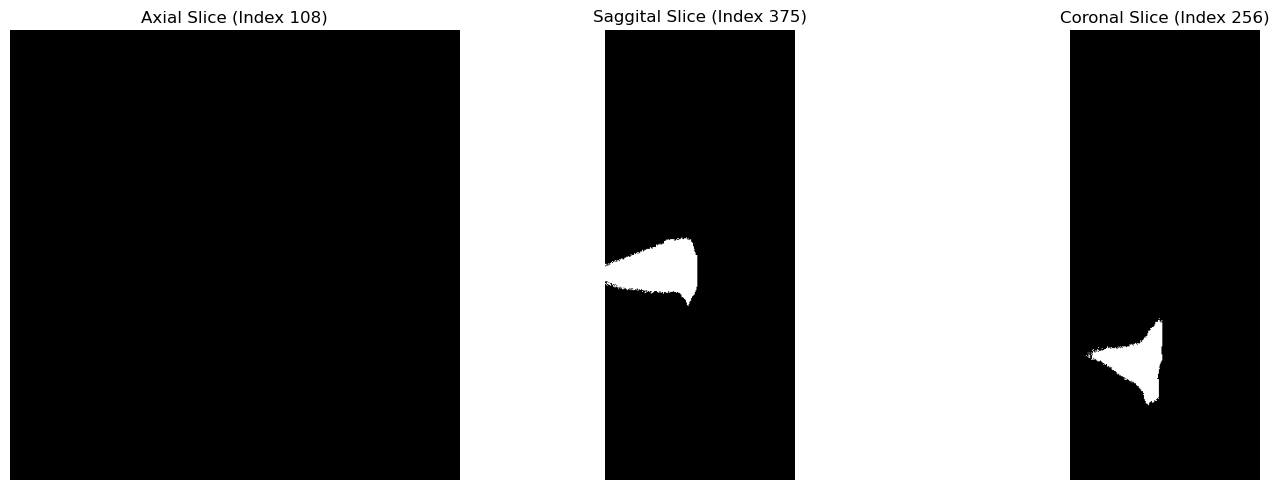

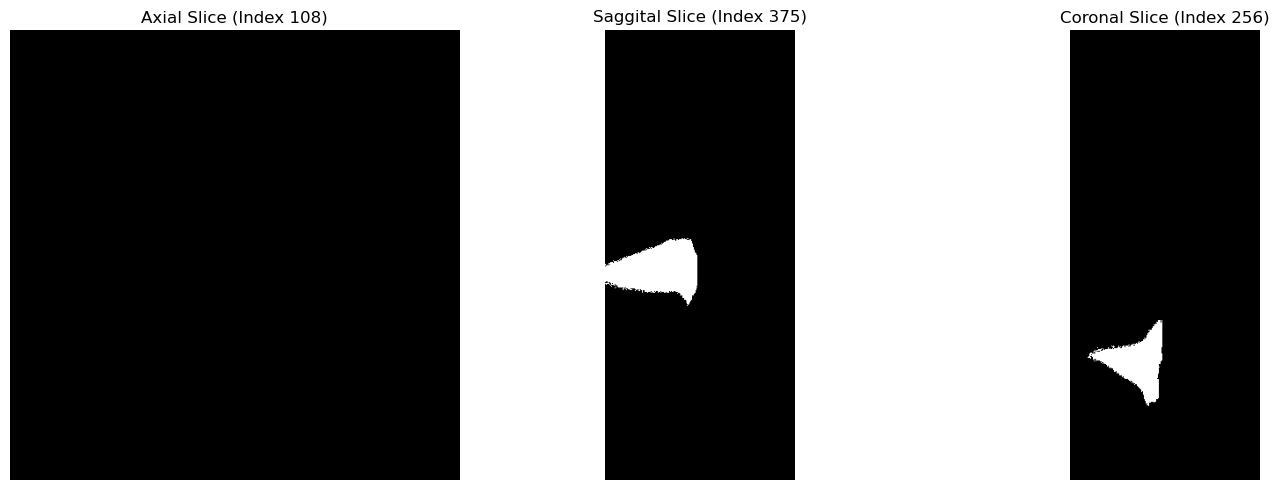

In [16]:
plot_slices(rand_mask1)
plot_slices(rand_mask2)

In [17]:
missing_tibia = tibia_mask & (~rand_mask1.astype(bool))
print(f"Missing tibia voxels in randomized mask: {np.sum(missing_tibia)}")



Missing tibia voxels in randomized mask: 0


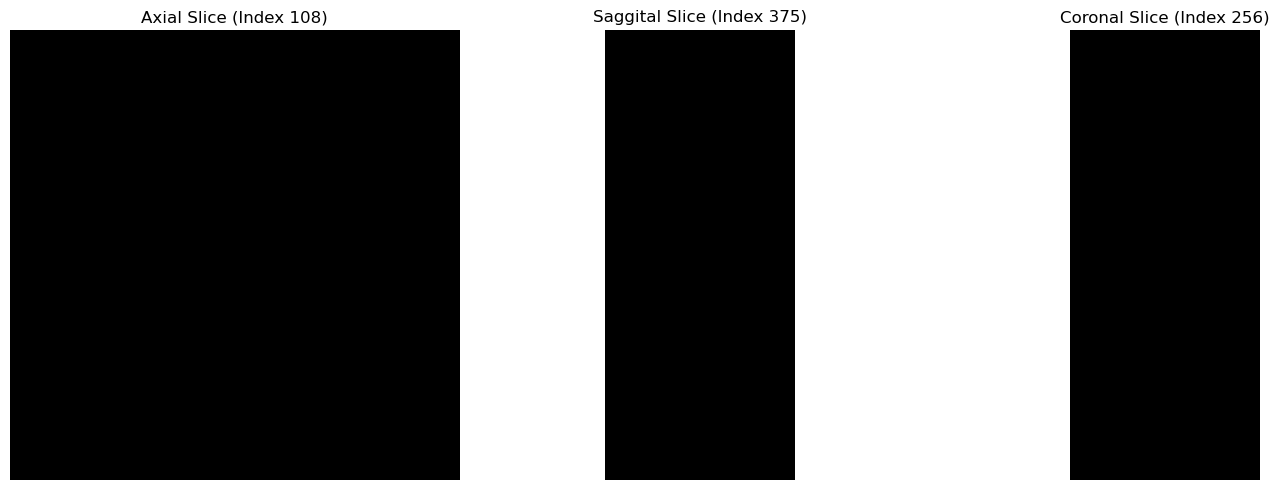

In [18]:
original_tibia = (mask == 2)
randomized_tibia = (rand_mask1 == 2)
missing_tibia = original_tibia & (~randomized_tibia)
plot_slices(missing_tibia)


In [19]:
rand_1_img = nib.Nifti1Image(rand_mask1.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(rand_1_img, Path("../results")/'task4_randomized_mask_1.nii.gz')


In [20]:
rand_2_img = nib.Nifti1Image(rand_mask2.astype(np.uint8), mask_vol.affine, mask_vol.header)
nib.save(rand_2_img, Path("../results")/'task4_randomized_mask_2.nii.gz')


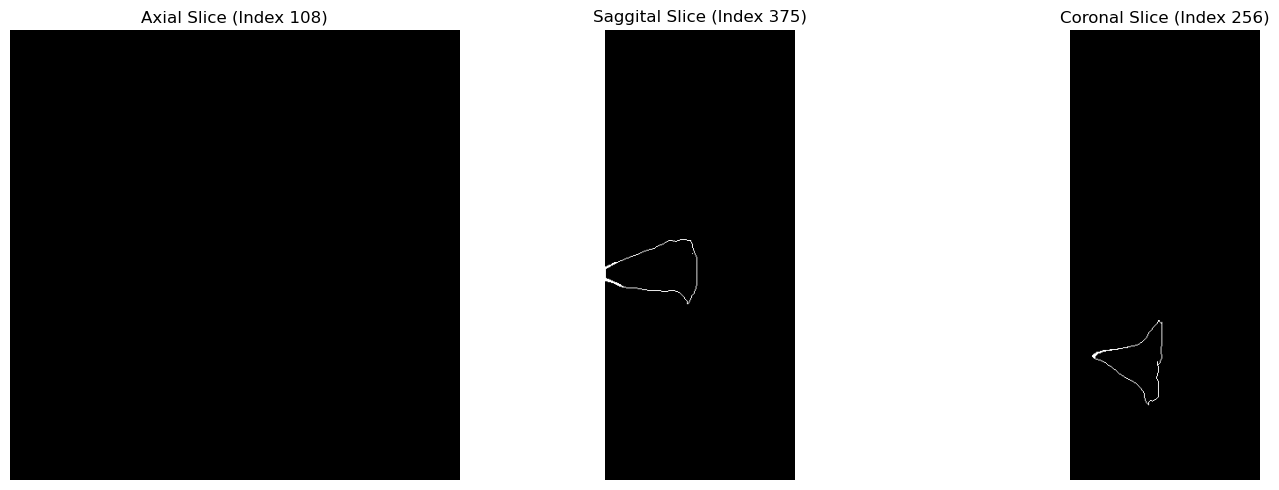

In [21]:
from scipy.ndimage import binary_erosion
eroded = binary_erosion(tibia_mask)
surface = tibia_mask & (~eroded)

plot_slices(surface)


In [22]:
import nibabel as nib
import numpy as np
from skimage.measure import marching_cubes
import os

def get_surface_points(mask):
    # Use marching cubes to extract surface points
    verts, faces, normals, _ = marching_cubes(mask, level=0.5)
    return verts

def find_medial_lateral_lowest_points(verts):
    # Split by midline along x-axis (adjust axis if needed)
    midline = np.median(verts[:, 0])
    medial = verts[verts[:, 0] < midline]
    lateral = verts[verts[:, 0] >= midline]

    medial_lowest = medial[np.argmin(medial[:, 2])]  # lowest z
    lateral_lowest = lateral[np.argmin(lateral[:, 2])]  # lowest z

    return medial_lowest, lateral_lowest

def process_mask(file_path):
    # Load mask
    mask_nii = nib.load(file_path)
    mask = mask_nii.get_fdata()
    affine = mask_nii.affine
    
    world_coord = np.array([0, 0, -750, 1])
    inv_affine = np.linalg.inv(affine)
    voxel_coord = inv_affine @ world_coord
    voxel_z_cutoff = voxel_coord[2]
    # Get surface and find landmarks
    verts = get_surface_points(mask)
    proximal_verts = verts[verts[:, 2] > voxel_z_cutoff]

    medial, lateral = find_medial_lateral_lowest_points(proximal_verts)

    # Convert from voxel to world coordinates
    medial_world = nib.affines.apply_affine(affine, medial)
    lateral_world = nib.affines.apply_affine(affine, lateral)
    verts_world = nib.affines.apply_affine(affine, proximal_verts)
    return medial_world, lateral_world, verts_world


In [23]:
medial_world, lateral_world, verts = process_mask("../results/task_4_tibia_mask.nii.gz")

In [24]:
medial_world, lateral_world, verts

(array([ -79.09192097,  -11.29892433, -749.5       ]),
 array([-106.90443242,  -34.76573086, -749.5       ]),
 array([[ -56.92882591,  -13.03720629, -700.5       ],
        [ -57.36339641,  -13.03720629, -701.5       ],
        [ -57.36339641,  -12.6026358 , -700.5       ],
        ...,
        [-151.66519302,  -27.812603  , -710.5       ],
        [-151.66519302,  -28.68174398, -712.5       ],
        [-151.66519302,  -28.68174398, -710.5       ]]))

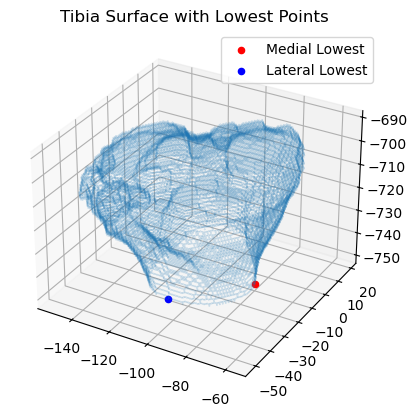

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Show tibia surface
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], s=0.1, alpha=0.3)

# Overlay lowest points (in voxel coordinates or apply inverse transform if needed)
ax.scatter(*medial_world[:3], color='red', label='Medial Lowest')
ax.scatter(*lateral_world[:3], color='blue', label='Lateral Lowest')

ax.set_title("Tibia Surface with Lowest Points")
ax.legend()
plt.show()


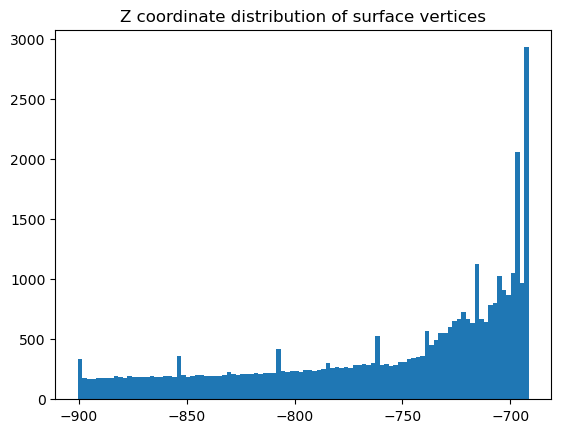

In [75]:
# verts = your surface vertices (N, 3) in voxel or world coords

# Visualize Z distribution
import matplotlib.pyplot as plt
plt.hist(verts[:, 2], bins=100)
plt.title('Z coordinate distribution of surface vertices')
plt.show()

# Pick cutoff manually from histogram, e.g. z_cutoff = -750 (world units)
proximal_verts = verts[verts[:, 2] > -750]

# Then proceed with medial/lateral split and lowest point search on proximal_verts


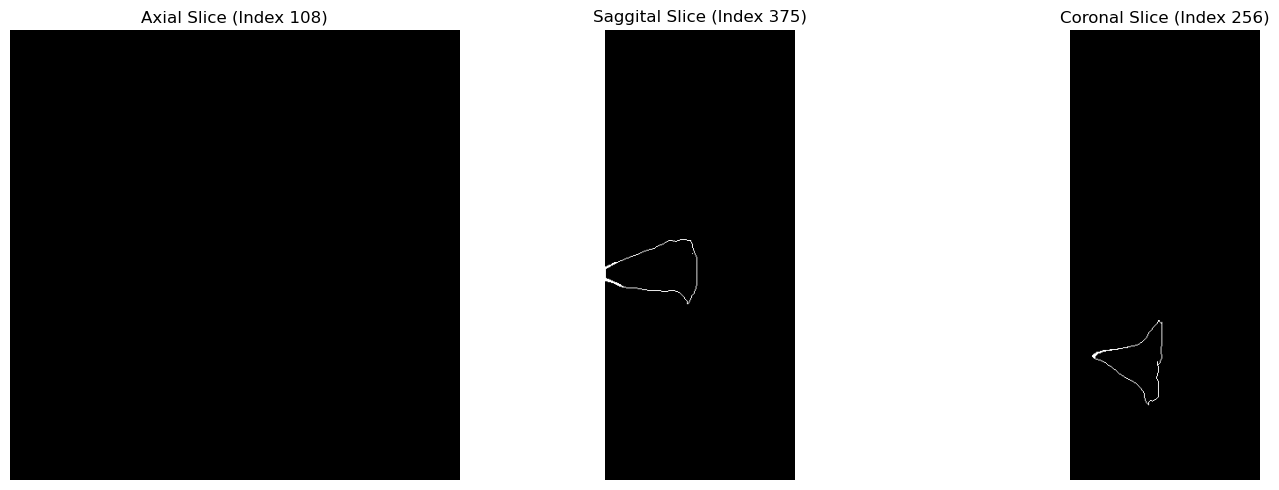

In [282]:
from scipy.ndimage import binary_erosion

tibia_mask_bool = tibia_mask.astype(bool)
eroded_mask = binary_erosion(tibia_mask_bool)

surface_mask = tibia_mask_bool & (~eroded_mask)

# Now you can plot slices or visualize
plot_slices(surface_mask)


In [283]:
surface_voxels = np.array(np.nonzero(surface_mask)).T  # Nx3 voxel indices


In [284]:
surface_coords = nib.affines.apply_affine(affine, surface_voxels)


In [291]:
# Calculate the 85th percentile of the z-coordinates to keep the top 15% highest points
z_threshold = np.percentile(surface_coords[:, 2], 95)

# Filter points that are on the plateau (top 15% along z-axis)
plateau_points = surface_coords[surface_coords[:, 2] >= z_threshold]

In [292]:
plateau_points[:, 1]

array([ -9.56064236, -10.42978334, -11.29892433, ..., -19.12119317,
       -19.99033415, -20.85947514])

In [293]:
x_coords = plateau_points[:, 0]
mid_x = np.median(x_coords)

medial_points = plateau_points[x_coords < mid_x]
lateral_points = plateau_points[x_coords > mid_x]


In [294]:
medial_lowest = medial_points[np.argmin(medial_points[:, 2])]
lateral_lowest = lateral_points[np.argmin(lateral_points[:, 2])]


In [295]:
medial_lowest, lateral_lowest

(array([ -86.04504883,    2.6073314 , -692.5       ]),
 array([ -60.83996034,   -9.56064236, -692.5       ]))

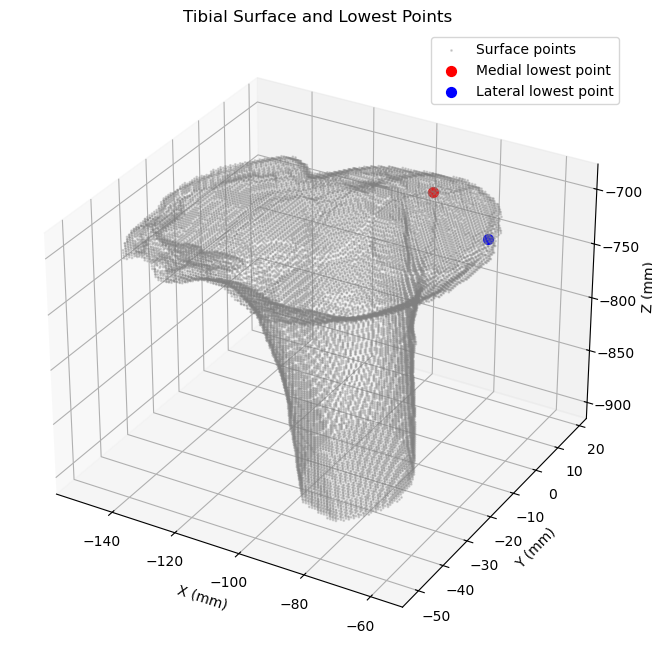

In [296]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 needed for 3d projection

# surface_coords is Nx3 array of surface points
# medial_lowest and lateral_lowest are 1x3 arrays of points

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all surface points lightly
ax.scatter(surface_coords[:, 0], surface_coords[:, 1], surface_coords[:, 2], 
           color='gray', alpha=0.3, s=1, label='Surface points')

# Plot medial lowest point in red
ax.scatter(medial_lowest[0], medial_lowest[1], medial_lowest[2], 
           color='red', s=50, label='Medial lowest point')

# Plot lateral lowest point in blue
ax.scatter(lateral_lowest[0], lateral_lowest[1], lateral_lowest[2], 
           color='blue', s=50, label='Lateral lowest point')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.legend()
plt.title('Tibial Surface and Lowest Points')
plt.show()


In [331]:

z_indices = np.where(np.any(np.any(tibia_mask, axis=0), axis=0))[0]
top_slices = z_indices[-20:]  # adjust 10 slices as needed

plateau_mask = np.zeros_like(mask)
plateau_mask[:, :, top_slices] = tibia_mask[:, :, top_slices]

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

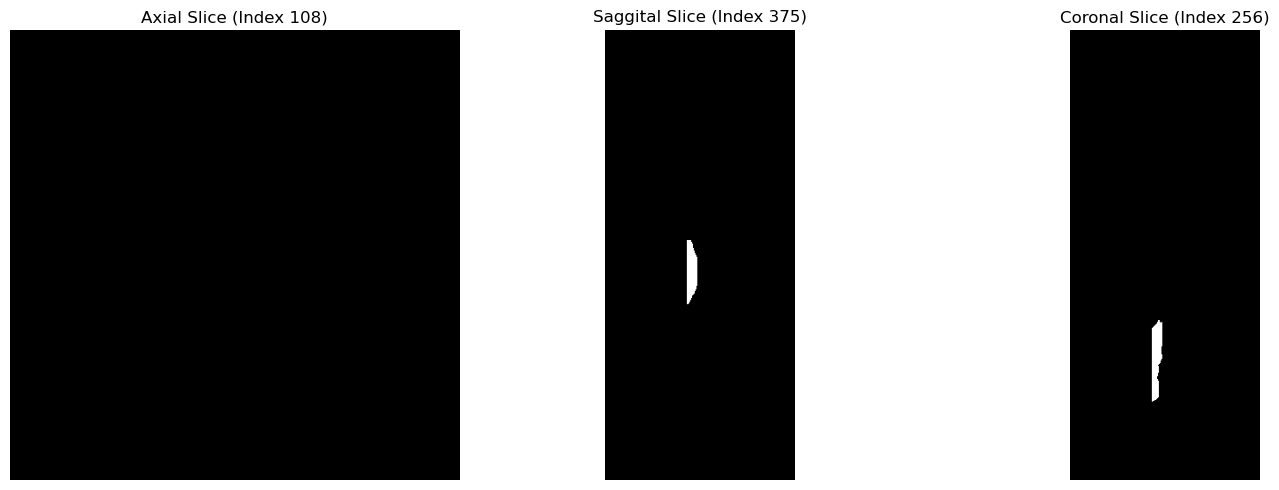

In [94]:
plot_slices(plateau_mask)

In [150]:
from skimage import measure

verts, faces, _, _ = measure.marching_cubes(plateau_mask, level=0.5)


In [151]:
print("X range:", verts[:, 0].min(), verts[:, 0].max())
print("Y range:", verts[:, 1].min(), verts[:, 1].max())
print("Z range:", verts[:, 2].min(), verts[:, 2].max())


X range: 321.5 430.5
Y range: 235.5 315.5
Z range: 84.5 104.5


In [152]:
median_x = np.median(verts[:, 0])
median_x = np.median(verts[:, 0])
print(f'Median x value: {median_x}')

Median x value: 378.0


In [153]:
# For left tibia:
medial_points = verts[verts[:, 0] >= median_x]  # medial side (closer to midline)
lateral_points = verts[verts[:, 0] < median_x]  # lateral side (outer side)

print(f'Number of medial points: {len(medial_points)}')
print(f'Number of lateral points: {len(lateral_points)}')

Number of medial points: 11314
Number of lateral points: 10961


In [154]:
# Now find the lowest points on z axis on each side
medial_lowest = medial_points[np.argmin(medial_points[:, 2])]
lateral_lowest = lateral_points[np.argmin(lateral_points[:, 2])]

print(f'Medial lowest point: {medial_lowest}')
print(f'Lateral lowest point: {lateral_lowest}')

Medial lowest point: [378.  237.   84.5]
Lateral lowest point: [339.  274.   84.5]


In [106]:
print("Original mask shape:", tibia_mask.shape)
print("Plateau mask shape:", plateau_mask.shape)


Original mask shape: (512, 512, 216)
Plateau mask shape: (512, 512, 216)


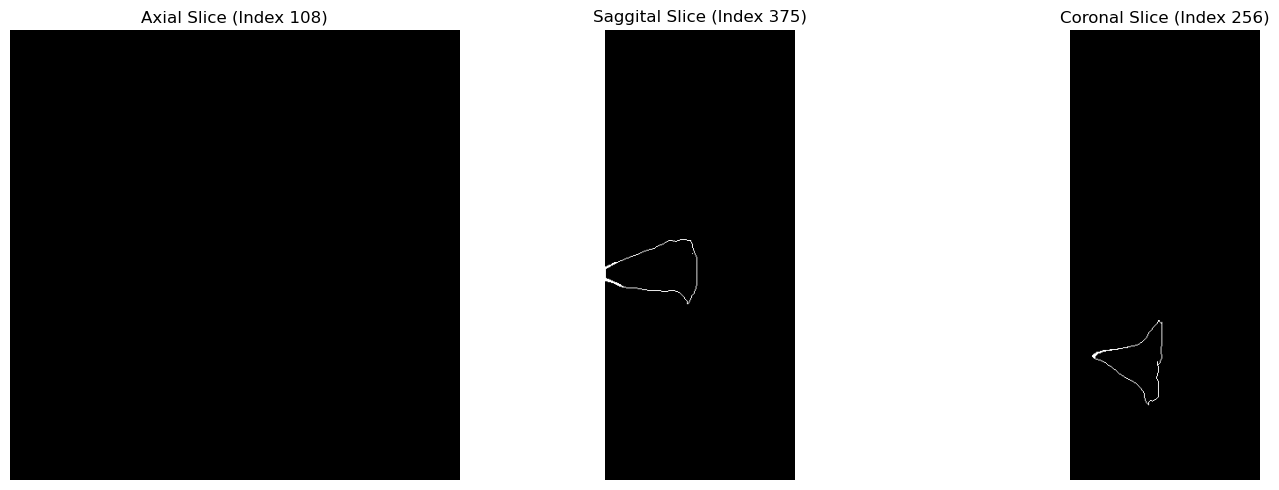

In [168]:
eroded_mask = binary_erosion(tibia_mask)
surface_mask = tibia_mask.astype(bool) ^ eroded_mask
plot_slices(surface_mask)

In [169]:
surface_coords = np.array(np.nonzero(surface_mask)).T  # shape (N_points, 3), voxel indices


In [ ]:
# 4. Convert voxel coordinates to LPS world coordinates (in mm)
surface_coords_mm = nib.affines.apply_affine(mask.affine, surface_coords)  # shape (N_points, 3)

In [171]:
# 5. Find the maximum Z coordinate of the surface (superior end of tibia)
z_max = np.max(surface_coords_mm[:, 2])

In [182]:
# 6. Define the tibial plateau thickness (e.g., top 10 mm)
plateau_thickness_mm = 2


In [183]:
# 7. Calculate the cutoff Z value to isolate the tibial plateau slab
z_cutoff = z_max - plateau_thickness_mm


In [184]:
# 8. Select only the surface points within the tibial plateau slab (top ~10 mm)
plateau_points = surface_coords_mm[surface_coords_mm[:, 2] >= z_cutoff]

In [185]:
# 9. Find median X value to split points into medial and lateral sides
mid_x = np.median(plateau_points[:, 0])

In [186]:
# 10. Select medial points (X < median)
medial_points = plateau_points[plateau_points[:, 0] < mid_x]



In [187]:
# 11. Select lateral points (X >= median)
lateral_points = plateau_points[plateau_points[:, 0] >= mid_x]

In [188]:
# 12. Find medial lowest point (point with minimum Z in medial points)
medial_lowest_index = np.argmin(medial_points[:, 2])
medial_lowest_point = medial_points[medial_lowest_index]

In [189]:
# 13. Find lateral lowest point (point with minimum Z in lateral points)
lateral_lowest_index = np.argmin(lateral_points[:, 2])
lateral_lowest_point = lateral_points[lateral_lowest_index]

In [190]:
# 14. Print the results (coordinates in LPS mm)
print("Medial lowest point on tibial plateau (LPS mm):", medial_lowest_point)
print("Lateral lowest point on tibial plateau (LPS mm):", lateral_lowest_point)

Medial lowest point on tibial plateau (LPS mm): [ -91.25989473    9.56045926 -694.5       ]
Lateral lowest point on tibial plateau (LPS mm): [ -59.97081935   -9.56064236 -694.5       ]


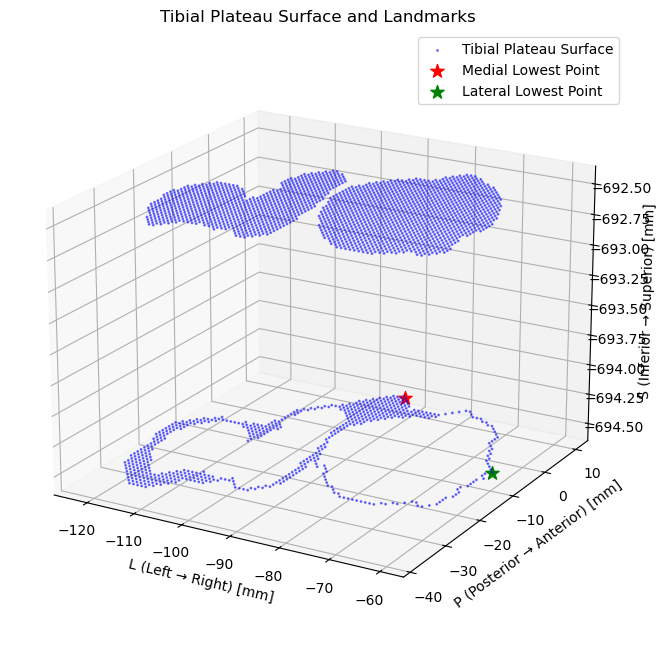

In [191]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

# Create a 3D scatter plot of the tibial plateau surface points
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all tibial plateau surface points as small blue dots
ax.scatter(plateau_points[:, 0], plateau_points[:, 1], plateau_points[:, 2], 
           c='blue', s=1, alpha=0.5, label='Tibial Plateau Surface')

# Plot medial lowest point as a large red star
ax.scatter(medial_lowest_point[0], medial_lowest_point[1], medial_lowest_point[2], 
           c='red', s=100, marker='*', label='Medial Lowest Point')

# Plot lateral lowest point as a large green star
ax.scatter(lateral_lowest_point[0], lateral_lowest_point[1], lateral_lowest_point[2], 
           c='green', s=100, marker='*', label='Lateral Lowest Point')

# Set labels for axes (L, P, S)
ax.set_xlabel('L (Left → Right) [mm]')
ax.set_ylabel('P (Posterior → Anterior) [mm]')
ax.set_zlabel('S (Inferior → Superior) [mm]')

# Set title and legend
ax.set_title('Tibial Plateau Surface and Landmarks')
ax.legend()

# Optional: Adjust the view angle for better visualization
ax.view_init(elev=20, azim=-60)

plt.show()


In [200]:
print(mask_vol.affine)

[[-8.69140983e-01  0.00000000e+00  0.00000000e+00  2.22500000e+02]
 [ 0.00000000e+00 -8.69140983e-01  0.00000000e+00  2.22500000e+02]
 [ 0.00000000e+00  0.00000000e+00  2.00000000e+00 -9.00500000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [301]:
plateau_thickness = 10  # Number of slices at the top, tune if needed
plateau_start = max(z_max - plateau_thickness + 1, 0)
plateau_end = z_max + 1

print(f"Isolating plateau region slices from {plateau_start} to {plateau_end - 1}")

plateau_mask = np.zeros_like(tibia_mask)
plateau_mask[:, :, plateau_start:plateau_end] = tibia_mask[:, :, plateau_start:plateau_end]


Isolating plateau region slices from 95 to 104


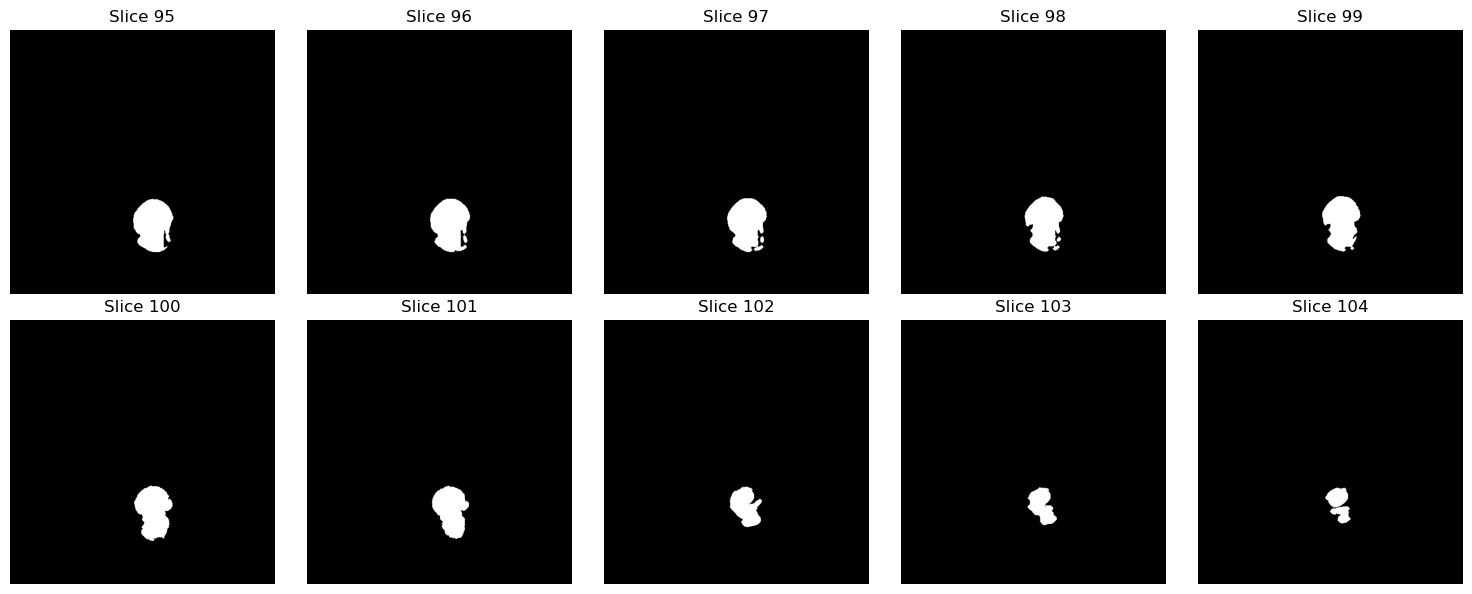

In [303]:
start_slice = plateau_start
end_slice = plateau_end
num_slices = end_slice - start_slice
cols = 5
rows = (num_slices + cols - 1) // cols  # Ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
axes = axes.flatten()

for idx, i in enumerate(range(start_slice, end_slice)):
    axes[idx].imshow(plateau_mask[:, :, i], cmap='gray')
    axes[idx].set_title(f'Slice {i}')
    axes[idx].axis('off')

# Hide unused subplots if any
for j in range(idx+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Vertices count: 17736


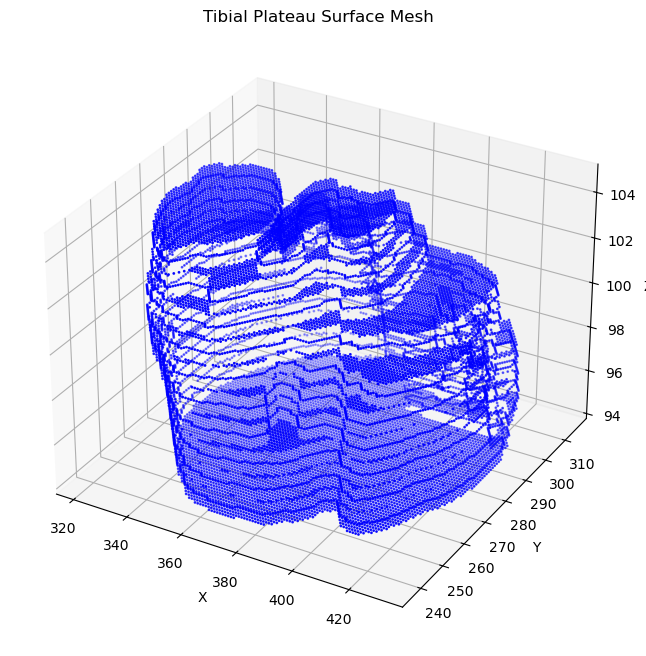

In [305]:
 #Define plateau slice range (based on your visualization)
plateau_start = 95
plateau_end = 105  # exclusive

# Create mask for tibial plateau slices only
plateau_mask = np.zeros_like(tibia_mask)
plateau_mask[:, :, plateau_start:plateau_end] = tibia_mask[:, :, plateau_start:plateau_end]

# Run marching cubes on plateau_mask
verts, faces, normals, values = measure.marching_cubes(plateau_mask, level=0.5)

print(f"Vertices count: {len(verts)}")

# Optional visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2], s=1, c='blue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Tibial Plateau Surface Mesh')
plt.show()

In [306]:
voxel_sizes = tibia_img.header.get_zooms()
print(f"Voxel spacing (X, Y, Z): {voxel_sizes}")

Voxel spacing (X, Y, Z): (0.869141, 0.869141, 2.0)


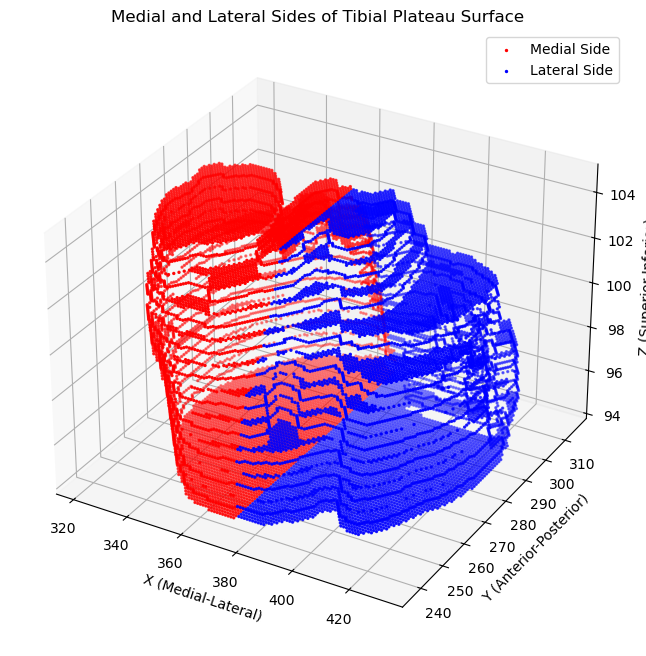

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# Assuming `verts` contains your plateau surface vertices from marching cubes
# verts shape: (N, 3) corresponding to (X, Y, Z)

medial_lateral_axis = 0  # usually X-axis

# Find median along medial-lateral axis
median_x = np.median(verts[:, medial_lateral_axis])

# Split points
medial_points = verts[verts[:, medial_lateral_axis] < median_x]
lateral_points = verts[verts[:, medial_lateral_axis] >= median_x]

# Plot medial and lateral points with different colors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(medial_points[:, 0], medial_points[:, 1], medial_points[:, 2], s=2, c='red', label='Medial Side')
ax.scatter(lateral_points[:, 0], lateral_points[:, 1], lateral_points[:, 2], s=2, c='blue', label='Lateral Side')

ax.set_xlabel('X (Medial-Lateral)')
ax.set_ylabel('Y (Anterior-Posterior)')
ax.set_zlabel('Z (Superior-Inferior)')
ax.legend()
plt.title('Medial and Lateral Sides of Tibial Plateau Surface')
plt.show()


Medial lowest point: [328.  274.   94.5]
Lateral lowest point: [375.  239.   94.5]


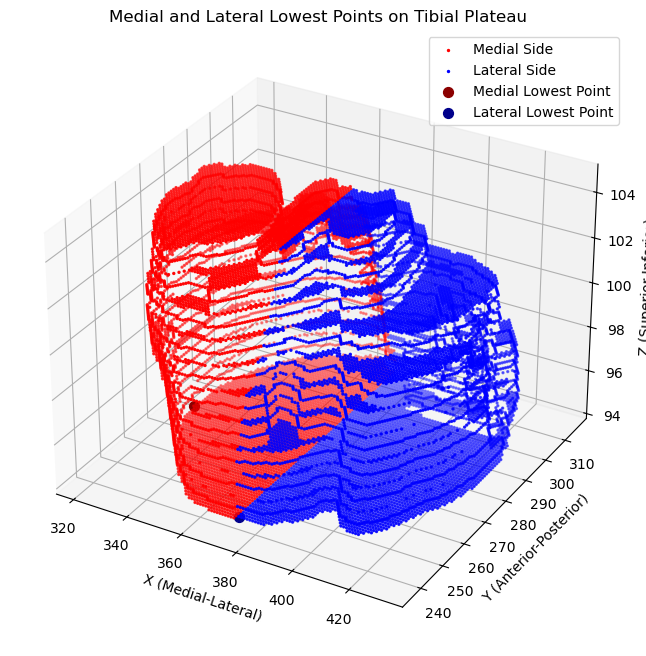

In [308]:
# vertical axis is Z-axis (axis=2)
vertical_axis = 2

# Find index of lowest Z coordinate in medial points
medial_lowest_idx = medial_points[:, vertical_axis].argmin()
medial_lowest_point = medial_points[medial_lowest_idx]

# Find index of lowest Z coordinate in lateral points
lateral_lowest_idx = lateral_points[:, vertical_axis].argmin()
lateral_lowest_point = lateral_points[lateral_lowest_idx]

print("Medial lowest point:", medial_lowest_point)
print("Lateral lowest point:", lateral_lowest_point)

# Optional: plot these lowest points on existing plot

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot all medial and lateral points
ax.scatter(medial_points[:, 0], medial_points[:, 1], medial_points[:, 2], s=2, c='red', label='Medial Side')
ax.scatter(lateral_points[:, 0], lateral_points[:, 1], lateral_points[:, 2], s=2, c='blue', label='Lateral Side')

# Plot lowest points
ax.scatter(medial_lowest_point[0], medial_lowest_point[1], medial_lowest_point[2], s=50, c='darkred', marker='o', label='Medial Lowest Point')
ax.scatter(lateral_lowest_point[0], lateral_lowest_point[1], lateral_lowest_point[2], s=50, c='darkblue', marker='o', label='Lateral Lowest Point')

ax.set_xlabel('X (Medial-Lateral)')
ax.set_ylabel('Y (Anterior-Posterior)')
ax.set_zlabel('Z (Superior-Inferior)')
ax.legend()
plt.title('Medial and Lateral Lowest Points on Tibial Plateau')
plt.show()


In [309]:
medial_voxel = np.round(medial_lowest_point).astype(int)
lateral_voxel = np.round(lateral_lowest_point).astype(int)

print("Medial lowest voxel index:", medial_voxel)
print("Lateral lowest voxel index:", lateral_voxel)


Medial lowest voxel index: [328 274  94]
Lateral lowest voxel index: [375 239  94]


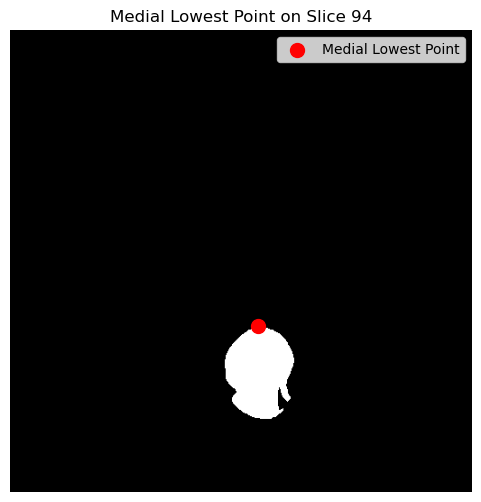

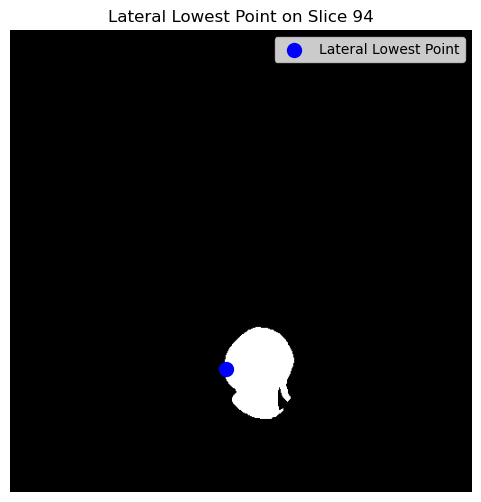

In [310]:
import matplotlib.pyplot as plt

# Extract slices at medial and lateral points
slice_medial = medial_voxel[2]  # Z index
slice_lateral = lateral_voxel[2]  # Z index

# Plot medial point slice
plt.figure(figsize=(6,6))
plt.imshow(tibia_mask[:, :, slice_medial], cmap='gray')
plt.scatter(medial_voxel[1], medial_voxel[0], c='red', s=100, label='Medial Lowest Point')
plt.title(f'Medial Lowest Point on Slice {slice_medial}')
plt.legend()
plt.axis('off')
plt.show()

# Plot lateral point slice
plt.figure(figsize=(6,6))
plt.imshow(tibia_mask[:, :, slice_lateral], cmap='gray')
plt.scatter(lateral_voxel[1], lateral_voxel[0], c='blue', s=100, label='Lateral Lowest Point')
plt.title(f'Lateral Lowest Point on Slice {slice_lateral}')
plt.legend()
plt.axis('off')
plt.show()


In [332]:
tibia_mask = tibia_mask.astype(bool)


In [333]:
# Prepare an array to hold the Z index of the top surface voxel for each (X,Y)
top_surface_z = np.full(tibia_mask.shape[:2], -1, dtype=int)

In [334]:
# Loop over each (X,Y) coordinate to find the highest Z where tibia exists
for x in range(tibia_mask.shape[0]):
    for y in range(tibia_mask.shape[1]):
        z_indices = np.where(tibia_mask[x, y, :])[0]
        if z_indices.size > 0:
            top_surface_z[x, y] = z_indices.max()

# Extract coordinates of top surface voxels where valid
valid_coords = np.where(top_surface_z != -1)
top_surface_points = np.vstack((valid_coords[0], valid_coords[1], top_surface_z[valid_coords])).T

print(f"Number of top surface voxels found: {len(top_surface_points)}")


Number of top surface voxels found: 6829


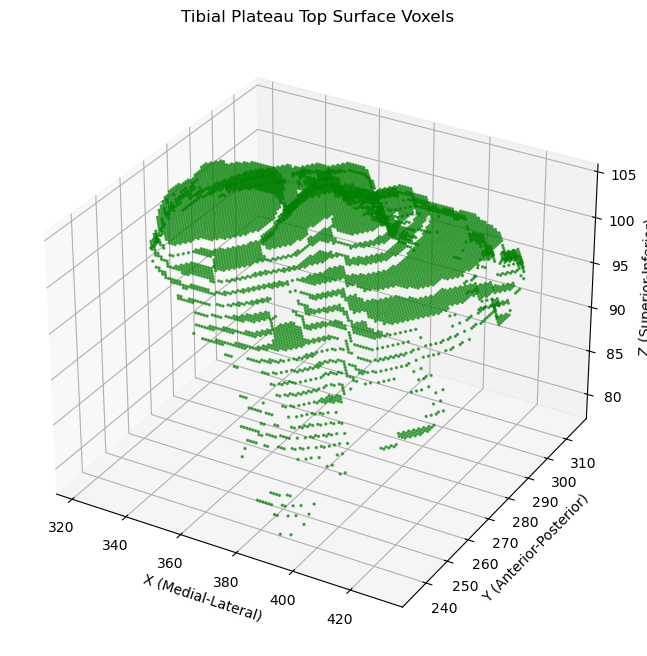

In [335]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

# Assume top_surface_points is a numpy array of shape (N, 3) with (x, y, z) coordinates

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(top_surface_points[:, 0], top_surface_points[:, 1], top_surface_points[:, 2], 
           c='green', s=2, alpha=0.6)

ax.set_xlabel('X (Medial-Lateral)')
ax.set_ylabel('Y (Anterior-Posterior)')
ax.set_zlabel('Z (Superior-Inferior)')
plt.title('Tibial Plateau Top Surface Voxels')
plt.show()


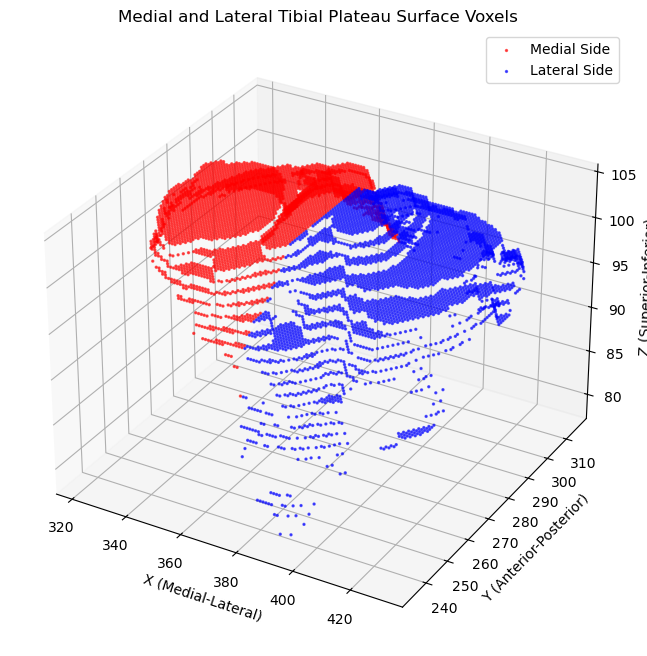

In [336]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

medial_lateral_axis = 0  # x-axis

median_x = np.median(top_surface_points[:, medial_lateral_axis])

# Split points
medial_points = top_surface_points[top_surface_points[:, medial_lateral_axis] < median_x]
lateral_points = top_surface_points[top_surface_points[:, medial_lateral_axis] >= median_x]

# Plot medial and lateral points with different colors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(medial_points[:, 0], medial_points[:, 1], medial_points[:, 2], 
           c='red', s=2, alpha=0.6, label='Medial Side')

ax.scatter(lateral_points[:, 0], lateral_points[:, 1], lateral_points[:, 2], 
           c='blue', s=2, alpha=0.6, label='Lateral Side')

ax.set_xlabel('X (Medial-Lateral)')
ax.set_ylabel('Y (Anterior-Posterior)')
ax.set_zlabel('Z (Superior-Inferior)')
ax.legend()
plt.title('Medial and Lateral Tibial Plateau Surface Voxels')
plt.show()


Medial lowest point: [375 238  92]
Lateral lowest point: [391 235  79]


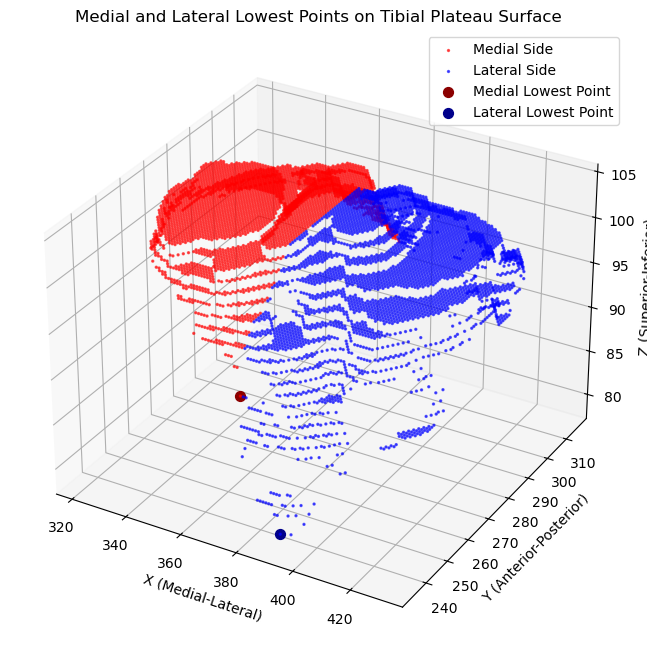

In [337]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

vertical_axis = 2  # Z-axis

# Find lowest point on medial side (minimum Z)
medial_lowest_idx = np.argmin(medial_points[:, vertical_axis])
medial_lowest_point = medial_points[medial_lowest_idx]

# Find lowest point on lateral side (minimum Z)
lateral_lowest_idx = np.argmin(lateral_points[:, vertical_axis])
lateral_lowest_point = lateral_points[lateral_lowest_idx]

print("Medial lowest point:", medial_lowest_point)
print("Lateral lowest point:", lateral_lowest_point)

# Plot medial and lateral points with lowest points highlighted
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot medial and lateral points
ax.scatter(medial_points[:, 0], medial_points[:, 1], medial_points[:, 2],
           c='red', s=2, alpha=0.6, label='Medial Side')
ax.scatter(lateral_points[:, 0], lateral_points[:, 1], lateral_points[:, 2],
           c='blue', s=2, alpha=0.6, label='Lateral Side')

# Plot lowest points
ax.scatter(medial_lowest_point[0], medial_lowest_point[1], medial_lowest_point[2],
           c='darkred', s=50, marker='o', label='Medial Lowest Point')
ax.scatter(lateral_lowest_point[0], lateral_lowest_point[1], lateral_lowest_point[2],
           c='darkblue', s=50, marker='o', label='Lateral Lowest Point')

ax.set_xlabel('X (Medial-Lateral)')
ax.set_ylabel('Y (Anterior-Posterior)')
ax.set_zlabel('Z (Superior-Inferior)')
ax.legend()
plt.title('Medial and Lateral Lowest Points on Tibial Plateau Surface')
plt.show()


In [338]:
# Your voxel coordinates as numpy arrays
medial_voxel = np.array(medial_lowest_point)
lateral_voxel = np.array(lateral_lowest_point)

# Convert voxel coordinates to world coordinates
medial_world = nib.affines.apply_affine(mask_vol.affine, medial_voxel)
lateral_world = nib.affines.apply_affine(mask_vol.affine, lateral_voxel)

print("Medial lowest point in world coords:", medial_world)
print("Lateral lowest point in world coords:", lateral_world)

Medial lowest point in world coords: [-103.42786849   15.64444613 -716.5       ]
Lateral lowest point in world coords: [-117.33412421   18.25186908 -742.5       ]


Medial voxel coords (int): [375 238  92]
Lateral voxel coords (int): [391 235  79]


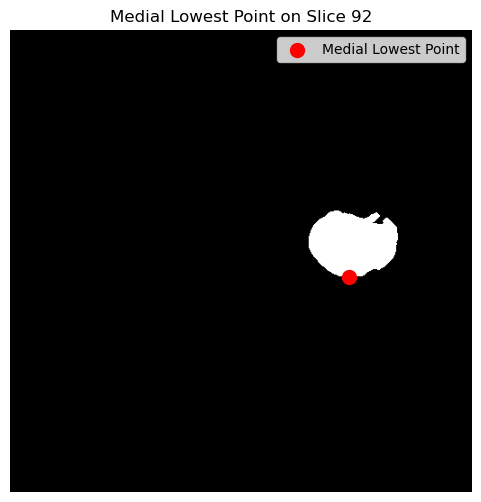

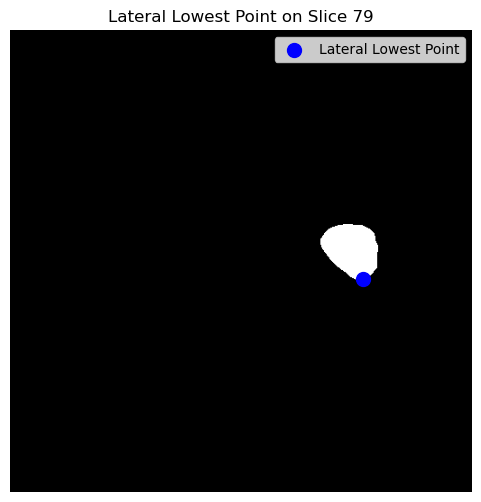

In [339]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Load your tibia mask image
tibia_img = nib.load('../results/task_4_tibia_mask.nii.gz')
affine = tibia_img.affine
tibia_mask = tibia_img.get_fdata()

# Medial and lateral points in world (LPS) coordinates
medial_world = np.array([-103.42786849, 15.64444613, -716.5])
lateral_world = np.array([-117.33412421, 18.25186908, -742.5])

# Compute inverse affine
inv_affine = np.linalg.inv(affine)

# Convert to voxel coordinates (float)
medial_voxel = nib.affines.apply_affine(inv_affine, medial_world)
lateral_voxel = nib.affines.apply_affine(inv_affine, lateral_world)

# Round to nearest integer voxel indices
medial_voxel_int = np.round(medial_voxel).astype(int)
lateral_voxel_int = np.round(lateral_voxel).astype(int)

print("Medial voxel coords (int):", medial_voxel_int)
print("Lateral voxel coords (int):", lateral_voxel_int)

# Plot medial point slice
slice_medial = medial_voxel_int[2]
mask_slice_medial = tibia_mask[:, :, slice_medial]

plt.figure(figsize=(6,6))
plt.imshow(mask_slice_medial.T, cmap='gray', origin='lower')
plt.scatter(medial_voxel_int[0], medial_voxel_int[1], c='red', s=100, label='Medial Lowest Point')
plt.title(f'Medial Lowest Point on Slice {slice_medial}')
plt.legend()
plt.axis('off')
plt.show()

# Plot lateral point slice
slice_lateral = lateral_voxel_int[2]
mask_slice_lateral = tibia_mask[:, :, slice_lateral]

plt.figure(figsize=(6,6))
plt.imshow(mask_slice_lateral.T, cmap='gray', origin='lower')
plt.scatter(lateral_voxel_int[0], lateral_voxel_int[1], c='blue', s=100, label='Lateral Lowest Point')
plt.title(f'Lateral Lowest Point on Slice {slice_lateral}')
plt.legend()
plt.axis('off')
plt.show()


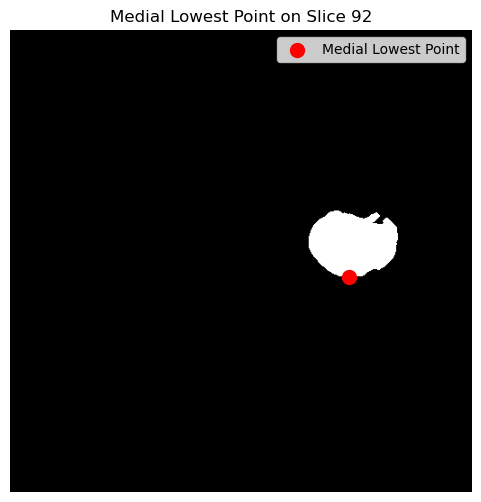

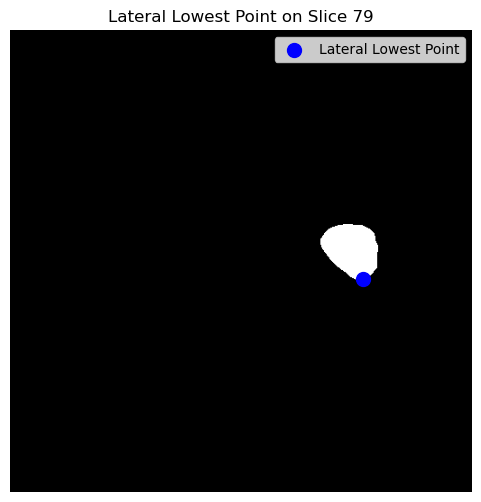

In [340]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Load the original mask
tibia_img = nib.load(path_to_tibia)
tibia_mask = tibia_img.get_fdata()
affine = tibia_img.affine
inv_affine = np.linalg.inv(affine)

# Your medial and lateral lowest points in world coordinates (LPS)
medial_world = np.array([-103.42786849, 15.64444613, -716.5])
lateral_world = np.array([-117.33412421, 18.25186908, -742.5])

# Convert world to voxel coordinates
medial_voxel = nib.affines.apply_affine(inv_affine, medial_world)
lateral_voxel = nib.affines.apply_affine(inv_affine, lateral_world)

# Round to integer voxel indices
medial_voxel_int = np.round(medial_voxel).astype(int)
lateral_voxel_int = np.round(lateral_voxel).astype(int)

# Extract slices for plotting
slice_medial = medial_voxel_int[2]
slice_lateral = lateral_voxel_int[2]

# Plot medial point on mask slice
plt.figure(figsize=(6, 6))
plt.imshow(tibia_mask[:, :, slice_medial].T, cmap='gray', origin='lower')
plt.scatter(medial_voxel_int[0], medial_voxel_int[1], color='red', s=100, label='Medial Lowest Point')
plt.title(f'Medial Lowest Point on Slice {slice_medial}')
plt.legend()
plt.axis('off')
plt.show()

# Plot lateral point on mask slice
plt.figure(figsize=(6, 6))
plt.imshow(tibia_mask[:, :, slice_lateral].T, cmap='gray', origin='lower')
plt.scatter(lateral_voxel_int[0], lateral_voxel_int[1], color='blue', s=100, label='Lateral Lowest Point')
plt.title(f'Lateral Lowest Point on Slice {slice_lateral}')
plt.legend()
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import nibabel as nib

def get_medial_lateral_lowest_points(tibia_nii_path):
    """
    Given a file path to a tibia segmentation mask (.nii), 
    returns the voxel coordinates of the medial and lateral lowest points 
    on the tibial plateau surface.

    Parameters:
    - tibia_nii_path: str, file path to the tibia segmentation mask (.nii)

    Returns:
    - medial_lowest_point: np.ndarray, shape (3,), voxel (x,y,z)
    - lateral_lowest_point: np.ndarray, shape (3,), voxel (x,y,z)
    """
    # Load mask and convert to boolean
    img = nib.load(tibia_nii_path)
    mask = img.get_fdata().astype(bool)

    # Step 1: Extract top surface voxels (max Z per (X,Y))
    top_surface_z = np.full(mask.shape[:2], -1, dtype=int)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            z_indices = np.where(mask[x, y, :])[0]
            if z_indices.size > 0:
                top_surface_z[x, y] = z_indices.max()

    valid_coords = np.where(top_surface_z != -1)
    top_surface_points = np.vstack((valid_coords[0], valid_coords[1], top_surface_z[valid_coords])).T

    # Step 2: Split into medial and lateral groups 
    median_x = np.median(top_surface_points[:, 0])
    medial_points = top_surface_points[top_surface_points[:, 0] < median_x]
    lateral_points = top_surface_points[top_surface_points[:, 0] >= median_x]

    # Step 3: Find lowest point (min Z) in each group
    vertical_axis = 2
    medial_lowest_point = medial_points[np.argmin(medial_points[:, vertical_axis])]
    lateral_lowest_point = lateral_points[np.argmin(lateral_points[:, vertical_axis])]
    
     # Convert voxel coordinates to world coordinates
    medial_lowest_point_world = nib.affines.apply_affine(img.affine, medial_lowest_point)
    lateral_lowest_point_world = nib.affines.apply_affine(img.affine, lateral_lowest_point)

    return medial_lowest_point_world, lateral_lowest_point_world

In [351]:
medial_lowest, lateral_lowest = get_medial_lateral_lowest_points("../results/task_4_tibia_mask.nii.gz")

In [352]:
medial_lowest, lateral_lowest 

(array([-103.42786849,   15.64444613, -716.5       ]),
 array([-117.33412421,   18.25186908, -742.5       ]))

In [354]:
get_medial_lateral_lowest_points("../results/task_4_randomized_mask_1.nii.gz")

(array([ -99.95130455,   17.3827281 , -720.5       ]),
 array([-114.72670126,   19.99015105, -746.5       ]))

In [355]:
get_medial_lateral_lowest_points("../results/task_4_randomized_mask_2.nii.gz")

(array([ -99.08216357,   17.3827281 , -718.5       ]),
 array([-114.72670126,   19.99015105, -744.5       ]))

In [356]:
get_medial_lateral_lowest_points("../results/task_4_tibia_mask_expanded_2mm.nii.gz")

(array([-103.42786849,   18.25186908, -722.5       ]),
 array([-118.20326519,   19.99015105, -742.5       ]))

In [357]:
get_medial_lateral_lowest_points("../results/task_4_tibia_mask_expanded_4mm.nii.gz")

(array([-103.42786849,   20.85929203, -728.5       ]),
 array([-119.07240617,   21.72843301, -742.5       ]))